In [2]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.26.4', '1.5.3', '0.20.3', '1.9.0']


In [33]:
### function to compute total effect from W
def compute_total_effect(W, source, target):
    T = np.zeros_like(W)  # Initialize total effect matrix
    W_power = W.copy()    # Current power of W (starts at W^1)
    
    # Iterate until W_power has no non-zero entries
    while np.any(W_power):
        T += W_power  # Accumulate effects from current path length
        W_power = W_power @ W  # Compute next power
        
    return T[source, target]


In [ ]:
# Using the total effect matrix to compute the total effect without iterative matrix power calculation, thus more efficient and numerically stable
def compute_total_effect(W, source, target):
    """
    Compute total effect from source to target using matrix inversion.
    
    Args:
        W (np.ndarray): Weighted adjacency matrix.
        source (int): Index of source variable.
        target (int): Index of target variable.
    
    Returns:
        float: Total effect from source to target.
    """
    try:
        I = np.eye(W.shape[0])
        T = np.linalg.inv(I - W) - I  # Compute total effect matrix
        return T[source, target]
    except np.linalg.LinAlgError:
        raise ValueError("Matrix inversion failed, likely due to cycles (I - W is singular).")


In [34]:
W = np.array([[0.0, 3.0, 2.0, -11.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 6.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 8.0,-1.0, 0.0, 0.0, 0.0],
              [0.0, 4.0, 0.0, 0.0, 0.0, 0.0]])

# total effect of X0 on X3 should be 10.0

# show the graph using graphviz
dot = make_dot(W.T) # Transpose W to make rows as source and columns as target
dot.render('total_effect', format='pdf', cleanup=True)

'total_effect.pdf'

In [35]:
from mixed_obs_data_generator import simulate_linear_mixed_sem

n = 1000
is_cont = np.ones(shape=(1, W.shape[0]))
# set 0 idx to 0 to indicate that the first variable is discrete
# set 1 idx to 0 to indicate that the second variable is discrete
is_cont[0, 0] = 0.0
is_cont[0, 1] = 0.0
print(is_cont)
sem_type = 'mixed_random_i_dis'
X = simulate_linear_mixed_sem(W=W, n_samples=n, is_cont=is_cont, sem_type=sem_type)
X_df = pd.DataFrame(X, columns=[f'x{i}' for i in range(X.shape[1])])
X_df.head()

[[0. 0. 1. 1. 1. 1.]]


,x0,x1,x2,x3,x4,x5
0,1.0,1.0,0.886918,-1.576497,1.657459,1.256161
1,0.0,1.0,0.184251,4.704964,0.756968,1.172128
2,1.0,1.0,2.360945,6.669432,0.128999,0.873003
3,0.0,1.0,1.036040,9.777315,0.198537,0.200981
4,0.0,1.0,0.448003,5.800797,0.412891,0.533156


In [54]:
# ICALiNGAM has estimate_total_effect method
model = lingam.ICALiNGAM()
model.fit(X=X)

# LiM does not have estimate_total_effect method
#model = lingam.LiM()
#model.fit(X=X, dis_con=is_cont, only_global=True)

W_est = model._adjacency_matrix.T # Transpose to make rows as source and columns as target

# x0 --> x3
te = model.estimate_total_effect(X, from_index=0, to_index=3) # index start from 0
print(f'total effect: {te:.3f}')

total effect: 1.102


/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


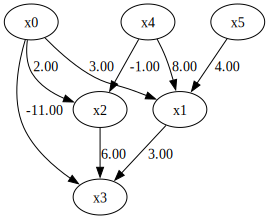

In [55]:
# show the graph
dot

In [58]:
# Compute total effect of X0 (source=0) on X3 (target=3)
true_total_effect = compute_total_effect(W, source=0, target=3)
print(f"True Total effect of X0 on X3: {true_total_effect}")

est_total_effect = compute_total_effect(W_est, source=0, target=3)
print(f"Estimated Total effect of X0 on X3: {est_total_effect}")

True Total effect of X0 on X3: 10.0
Estimated Total effect of X0 on X3: 1.166223553541347


In [1]:
from graphviz import Digraph
dot = Digraph()
dot.node('A')
dot.node('B')
dot.edge('A', 'B')
dot.render('test.gv')  # Should create test.gv.pdf

'test.gv.pdf'

In [ ]:
compute_total_effect